In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import copy
import os

# This notebook is to check difference between EPEC and Optimal System Cost

In [31]:
print("Loading results from:")
files_path = os.path.realpath(os.path.join(os.path.abspath(''), "Model_CSV"))
print("\t",files_path)
files_name = 'Model_data_DA_'
append_name ="_20221021-185407"
ncda = 9
#Model_data_DA_1_20221021-185407
data = []
for j in range(1,ncda+1):
    path = os.path.join(files_path,files_name+str(j)+append_name+'.csv')
    #print("Reading file {} : {}".format(j,path))
    data.append(pd.read_csv(path))

Loading results from:
	 D:\GitHub\PyomoModels\09_MPEC_Bidding_Diagonalization\MatlabCode\V06\ResultsAnalysis\Model_CSV


## Matlab optimal results

In [32]:
files_name = 'results_lin_comp_market_10-17-2022@20.41.xlsx'
lin_Competitive_Profit = pd.read_excel(files_name,'Competitive Profit', header=None)

## MPEC PROFIT / SYSTEM-COST: sum(Sell - Buy)*LMPs

In [79]:
da_loc = np.array([[0,0,0,0,0,0,0,0,0],
[0,0,0,0,0,0,0,0,0],
[1,1,1,0,0,0,0,0,0],
[0,0,0,1,1,1,0,0,0],
[0,0,0,0,0,0,1,1,1],
[0,0,0,0,0,0,0,0,0]])

bus_col = []
for i in range(1,7):
    bus_col.append('Bus'+str(i)+'_price')

MVA=30


bus_loc =[3,3,3,4,4,4,5,5,5]
bus_price = []

# for i in range(0,7):
#     bus_price.append(data[0][data[0].Iteration==25][bus_col[bus_loc[i]-1]].to_numpy().transpose())
    
bus_price = data[8][data[8].Iteration==25][bus_col].to_numpy().transpose()

da_sell_list=[]
for df in data:
    da_sell_list.append(df[df.Iteration==25]['DAs_generation\nE_DAs_G'].tolist())

da_buy_list=[]
for df in data:
    da_buy_list.append(df[df.Iteration==25]['DAs_load\nE_DAs_L'].tolist())

da_sell = np.array(da_sell_list)
da_buy  = np.array(da_buy_list)

price_mat = np.matmul(da_loc.T,bus_price)
amount_mat = da_sell*MVA-da_buy*MVA

EPEC_profit = np.multiply(amount_mat, price_mat)

(24,)

In [34]:
def compute_DAs_Systemcost(iteration, DA_no):
    da_loc = np.array([[0,0,0,0,0,0,0,0,0],
            [0,0,0,0,0,0,0,0,0],
            [1,1,1,0,0,0,0,0,0],
            [0,0,0,1,1,1,0,0,0],
            [0,0,0,0,0,0,1,1,1],
            [0,0,0,0,0,0,0,0,0]])

    bus_col = []
    for i in range(1,7):
        bus_col.append('Bus'+str(i)+'_price')
    
    MVA=30

    bus_price = data[DA_no][data[DA_no].Iteration==iteration][bus_col].to_numpy().transpose()
    
    da_sell_list=[]
    for df in data:
        da_sell_list.append(df[df.Iteration==iteration]['DAs_generation\nE_DAs_G'].tolist())
        
    da_buy_list=[]
    for df in data:
        da_buy_list.append(df[df.Iteration==iteration]['DAs_load\nE_DAs_L'].tolist())
        
    da_sell = np.array(da_sell_list)
    da_buy  = np.array(da_buy_list)
    
    price_mat = np.matmul(da_loc.T,bus_price)
    amount_mat = da_sell*MVA-da_buy*MVA
    
    Mpec_profit = np.multiply(amount_mat, price_mat)
    
    return Mpec_profit

In [35]:
das_cost = []

for it in data[0].Iteration.unique():
    if it!=0:
        das_cost.append(pd.DataFrame(compute_DAs_Systemcost(it, 0)).sum().to_list())
        
das_cost = pd.DataFrame(das_cost)


In [36]:
time_dict = dict(list(enumerate([x for x in range(16,40)])))

def change_time(df):
    for x in range(16,40):
        if x >=24:
            index = df[df['Time'] == x].index
            df.loc[index,'Time'] = df.Time[index]%24
    return df

In [37]:
das_cost = das_cost.rename(columns=time_dict)
das_cost = das_cost.drop(index=0)

In [38]:
lin_Competitive_Profit = lin_Competitive_Profit.rename(columns=time_dict)

In [46]:
lin_Competitive_Profit.sum().sum(), EPEC_profit.sum().sum()

(6314.264394602887, 301537.1730646966)

In [45]:
# fig, axes = plt.subplots(1, 1, figsize=(12, 6))
# X=[ x for x in range(len(das_cost.sum(axis=1)))]
# Y=das_cost.sum(axis=1)
# line1, = axes.plot(X,Y, label="EPEC")
# Y= [lin_Competitive_Profit.sum().sum() for x in range(len(das_cost.sum(axis=1)))]
# line2, =axes.plot(X,Y, label="Optimal")

# axes.legend([line1, line2], ["EPEC", "Optimal"])
# axes.set_xticks([x+1 for x in range(len(das_cost.sum(axis=1)))]);
# axes.set_xlabel("Iteration Number", fontsize=14)
# axes.set_ylabel("System Cost $", fontsize=14)
# axes.set_title("EPEC System cost VS Optimal", fontsize=14);

## Correct EPEC Profit vs Optimal

In [80]:
# From above
EPEC_profit = pd.DataFrame(EPEC_profit)
EPEC_profit = EPEC_profit.rename(columns=time_dict)

In [81]:
DA_1_EPEC_profit = EPEC_profit.sum(axis=1)[0]
DA_1_Opt_profit = lin_Competitive_Profit.sum(axis=1)[0]
print("Profit of DA1 in EPEC model {:.2f} VS in Optimal {:.2f} after 25 Iteration".format(DA_1_EPEC_profit,DA_1_Opt_profit))

Profit of DA1 in EPEC model 35146.27 VS in Optimal 751.58 after 25 Iteration


In [82]:
Df = pd.DataFrame({"Optimal":lin_Competitive_Profit.sum(axis=1), "MPEC":EPEC_profit.sum(axis=1), "DA":["DA"+str(x+1) for x in range(ncda)]})
Df = Df.melt(id_vars='DA', var_name='Model', value_name='Profit')

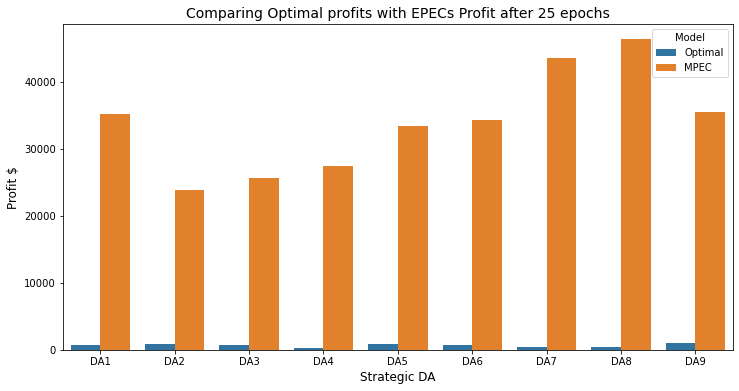

In [83]:
fig, axes = plt.subplots(1, 1, figsize=(12, 6))

sns.barplot(data= Df,  x='DA', y='Profit', hue='Model')#hue='category'
axes.set_title("Comparing Optimal profits with EPECs Profit after 25 epochs", fontsize=14)
axes.set_xlabel('Strategic DA',fontsize=12);
axes.set_ylabel('Profit $',fontsize=12);
#fig.savefig("Optimal_vs_MPEC_Profi_BarPlot.png", bbox_inches='tight')

In [77]:
EPEC_profit.sum(axis=1)

0    29289.049193
1    19968.733300
2    21265.890354
3    29674.545255
4    35921.403161
5    37077.299533
6    43937.244704
7    47252.504371
8    37150.503193
dtype: float64